### **Import the packages**

In [2]:
# !pip install tensorflow-gpu==2.0.0-rc1
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import numpy as np

### **Load MNIST dataset**

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data() # load the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0 # convert the data type to 'float'

## Channel
# Dimension of image == (pixel X pixel X Channel)
# Color image -> RGB (Red,Green,Blue) image == 3 Channel
# Grayscale image -> 1 Channel
# Example) The color image which have the shape: height : 39, width : 28
# ->> dimension of the image == (39,28,3)

# add the dimension of 'channel'
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

### **Apply 'Shuffle' and 'batch size' using tf.data API**

In [4]:
## tf.data API
# This gives us the efficient input pipeline to serve the dataset to model in the problem relate to images (specific)
# refer to:  https://www.kaggle.com/jalammar/intro-to-data-input-pipelines-with-tf-data

## Methods of tf.data
# .Dataset : create the dataset
# .from_tensor_slices : convert the data type to 'tf.Tensor'
# .shuffle : exchange the array / value randomly
# .batch : split (preallocate) the data to train the model

## buffer size in .shuffle (stackoverflow answer)
# If buffer size is 100, it means that Tensorflow will keep a buffer of the next 100 samples,
# and will randomly select one those 100 samples. it then adds the next element to the buffer.
# so, if buffer_size = 1 there is no shuffle at all,
# and if buffer_size > data_set_size a perfect uniform random shuffle is guaranteed.
# I would highly suggest to shuffle the data set before creating the TFrecords, and keep a small buffer size.

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size = 10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

### **Model construction**

In [5]:
# create the simple CNN model
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x): # call the model output for given new input
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

model = MyModel()

### **Choose the lossfunction and optimizer**

In [6]:
# choose the loss function and optimizer as 'default'
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

### **Divide into training, test**

In [7]:
# .Mean() : Computes the (weighted) mean of the given values
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### **Build training pipeline**

In [8]:
## tf.function
# TF 2.0에서 eager execution이 default 이다.
# eager 모드는 매우 직관적으로 유연한 UI를 제공하지만 performance와 deploy함에 있어서 expense를 갖는다.
# 즉 더 나은 performance와 deployability를 위해 graph모드를 병행 해야 하는데, tf.function을 활용해 코드에서 graph를 만들 수 있게 한다.
# 즉, TF 2.0은 TF 1.0의 연산 효율(graph)와 구현 용이(eager)를 통합하며 그 중심에 tf.function()이 있다
# @tf.function을 사용하면 파이썬 함수를 TF operation처럼 정의 할 수 있다.
# eagerly 실행 할 수 있고, graph 내에서 사용 할 수 있으며 물론 gradients도 갖는다.
# @tf.function annotation을 사용하면 함수처럼 호출 되지만 graph로 컴파일 된다.
# 그 말인 즉슨, GPU나 TPU위에서 빠른 실행을 시킬 수 있고 SaveModel을 통해 export도 가능하단 것.

@tf.function 
def train_step(images, labels): ### Model training
  with tf.GradientTape() as tape: # record the auto gradient as tape
    predictions = model(images)
    loss = loss_object(labels, predictions)
  # compute gradients for given loss with variables for training
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss) # mean loss
  train_accuracy(labels, predictions) # sparse categorical accuracy

### **Build test pipeline**

In [9]:
@tf.function
def test_step(images, labels): ### Model validation
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

### **Model training & test**

In [10]:
EPOCHS = 5

TRLO = []
TRA = []
TSLO = []
TSA = []

for epoch in range(EPOCHS):
  for images, labels in train_ds: # for the images and labels in our dataset
    train_step(images, labels) # training the model

  for test_images, test_labels in test_ds: # if the training process is done,
    test_step(test_images, test_labels) # testing the model (model prediction)

  template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))
  
  TRLO.append(train_loss.result())
  TRA.append(train_accuracy.result()*100)
  TSLO.append(test_loss.result())
  TSA.append(test_accuracy.result()*100)


에포크: 1, 손실: 0.13369518518447876, 정확도: 96.0566635131836, 테스트 손실: 0.060782305896282196, 테스트 정확도: 97.94999694824219
에포크: 2, 손실: 0.08846688270568848, 정확도: 97.37083435058594, 테스트 손실: 0.05583509802818298, 테스트 정확도: 98.15999603271484
에포크: 3, 손실: 0.06629770249128342, 정확도: 98.0111083984375, 테스트 손실: 0.055885981768369675, 테스트 정확도: 98.1933364868164
에포크: 4, 손실: 0.05308621749281883, 정확도: 98.39666748046875, 테스트 손실: 0.05614456161856651, 테스트 정확도: 98.24500274658203
에포크: 5, 손실: 0.04419223964214325, 정확도: 98.66300201416016, 테스트 손실: 0.056291062384843826, 테스트 정확도: 98.29199981689453


### **Visualization of Loss & Accuracy**

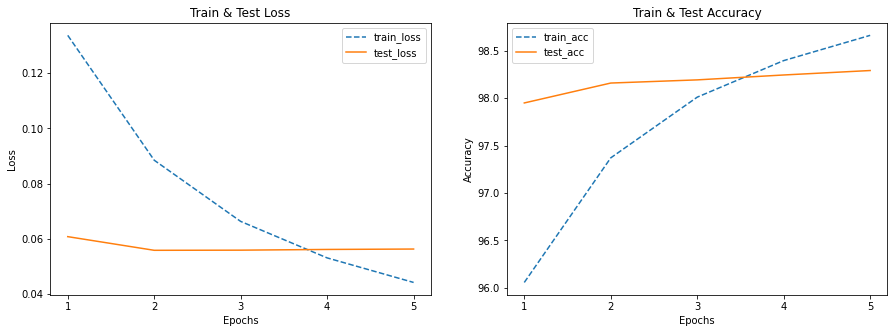

In [11]:
E = list(range(1,EPOCHS+1))

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(E,TRLO,'--',label = 'train_loss')
plt.plot(E,TSLO,label = 'test_loss')
plt.xticks(E)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(E,TRA,'--',label = 'train_acc')
plt.plot(E,TSA,label = 'test_acc')
plt.xticks(E)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy')
plt.legend()
plt.show()

### **Convert the output to digit form**

In [12]:
def get_digit(layer_output):
  pred = [] # list for containing 'digit'

  for i in range(len(layer_output)):
    max_val = 0 # the maximum of 10 probabilities
    ind = [] # the index of the maximum
    for j in range(len(layer_output[i])):

      if max_val < layer_output[i,j]: # criterion
        max_val = layer_output[i,j] # update
        ind.append(j) # save the index of each max_val

    pred.append(ind[-1]) # save the final max_val
  pred = np.array(pred) # convert the data type
  return pred

In [13]:
output = model.call(test_images).numpy()

print('** label: \n',test_labels.numpy())
print('\n** prediction: \n',get_digit(output))

** label: 
 [1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]

** prediction: 
 [1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6]
